# Create Cached Embeddings (DuckDB) from Long-Format Parquets

This notebook is a runnable, **manual step-by-step** workflow from **long-format** parquet extractions → **wide** time-series parquets → **merged** wide parquet → **DuckDB embeddings cache** populated with Presto embeddings.

Later in the notebook there is also a **script alternative** (`scripts/misc/build_embeddings_cache.py`) that performs the same pipeline end-to-end.

## Notebook flow

This notebook is organized as:

1) **Set parameters** (paths + parameters)
2) **Discover** long-format parquet files
3) **Inspect** a sample long parquet (schema + a small preview)
4) **Convert** long → wide with `worldcereal.utils.timeseries.process_parquet`
5) **Merge** wide parquets into one parquet (Arrow streaming, memory-safe)
6) **Compute** and store embeddings into a DuckDB cache via `worldcereal.train.embeddings_cache.compute_embeddings`
7) **Alternative**: run the pipeline script (optional)
8) **Explore** the DuckDB cache (stats + sampling + PCA plot)

Notes:
- DuckDB may throw a lock error if the same DB is open for writing in another process/kernel. Use a different DB path or close other connections.

In [1]:
from __future__ import annotations

from pathlib import Path

# -----------------------------
# User parameters (edit these)
# -----------------------------
user_home = Path("/home/vito/shahs")
# Optional: script alternative (used later in the notebook)
SCRIPT = user_home / "TestFolder/worldcereal-classification/scripts/misc/build_embeddings_cache.py"

# Long-format parquet input: can be a directory OR a single `.parquet` file
INPUT_LONG_DIR = user_home / "projects/worldcereal/data/worldcereal_all_extractions.parquet"
PARQUET_GLOB = "**/*.parquet"

# Wide parquet outputs (one per long parquet)
WIDE_DIR = user_home / "projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2"
WIDE_SUFFIX = "_ppq"
OVERWRITE_WIDE = False

# Merged wide parquet output (single file)
MERGED_WIDE_PATH = user_home / "projects/worldcereal/data/cached_wide_merged/worldcereal_all_extractions_wide_month2.parquet"
OVERWRITE_MERGED = False

# DuckDB embeddings cache output
EMBEDDINGS_DB_PATH = user_home / "projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated.duckdb"

# Presto checkpoint (URL or local path)
PRESTO_URL = (
    "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/"
    "PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
 )

# --------------
# Manual pipeline knobs
# --------------

# (A) long -> wide
FREQ = "month"  # 'month' or 'dekad'
REQUIRED_MIN_TIMESTEPS = None  # int | None
USE_VALID_TIME = True
MIN_EDGE_BUFFER = 1
MAX_TIMESTEPS_TRIM = 18  # int | 'auto' | None
WIDE_ENGINE = "pyarrow"  # 'pyarrow' or 'fastparquet'
WIDE_COMPRESSION = "snappy"

# Limit long files for quick iteration (set to None for all)
MAX_LONG_FILES = None  # e.g. 5

# (B) merge wide parquets
MERGE_BATCH_ROWS = 100_000
MERGE_ROW_GROUP_SIZE = 100_000
MERGE_COMPRESSION = "zstd"

# (C) embeddings cache population
BATCH_SIZE = 16_384
NUM_WORKERS = 2
PARQUET_BATCH_ROWS = 200_000
FORCE_RECOMPUTE = False
PREMATCH = True  # skip fully-cached parquet batches (for this model_hash)

assert INPUT_LONG_DIR.exists(), INPUT_LONG_DIR
print("Input:", INPUT_LONG_DIR)
print("Wide dir:", WIDE_DIR)
print("Merged wide:", MERGED_WIDE_PATH)
print("DB:", EMBEDDINGS_DB_PATH)

Input: /home/vito/shahs/projects/worldcereal/data/worldcereal_all_extractions.parquet
Wide dir: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2
Merged wide: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/worldcereal_all_extractions_wide_month2.parquet
DB: /home/vito/shahs/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated.duckdb


### 3) Convert long → wide via `process_parquet`

This writes one wide parquet per long parquet into `WIDE_DIR`.

In [2]:
import gc
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm

from worldcereal.utils.timeseries import process_parquet

def wide_out_path(wide_dir: Path, raw_path: Path, suffix: str = "_ppq") -> Path:
    return wide_dir / f"{raw_path.stem}{suffix}.parquet"

WIDE_DIR.mkdir(parents=True, exist_ok=True)
already_processed = 0
wide_files: list[Path] = []
empty_long: list[Path] = []
errored_long: list[Path] = []
raw_files = sorted(INPUT_LONG_DIR.glob(PARQUET_GLOB))
for pf in tqdm(raw_files, desc="process_parquet", unit="file"):
    out_path = wide_out_path(WIDE_DIR, pf, suffix=WIDE_SUFFIX)
    if out_path.exists() and not OVERWRITE_WIDE:
        print(f"Already exists, skipping: {out_path}")
        already_processed += 1
        wide_files.append(out_path)
        continue
    try:
        df_long = pd.read_parquet(pf)
        # check if sample_id is stored in the index in some upstream outputs
        if "sample_id" not in df_long.columns and "sample_id" in df_long.index.names:
            print("Resetting index to get sample_id column")
            df_long.reset_index(drop=True, inplace=True)
        df_wide = process_parquet(
            df_long,
            freq=FREQ,
            required_min_timesteps=REQUIRED_MIN_TIMESTEPS,
            use_valid_time=USE_VALID_TIME,
            min_edge_buffer=MIN_EDGE_BUFFER,
            max_timesteps_trim=MAX_TIMESTEPS_TRIM,
        )
    except Exception as e:
        print(f"ERROR processing {pf}: {type(e).__name__}: {e}")
        errored_long.append(pf)
        # don't continue , raise hell
        raise e
        # raise e
        
    if df_wide.empty:
        empty_long.append(pf)
        continue
    df_wide=df_wide.reset_index()
    df_wide.to_parquet(
        out_path,
        engine=WIDE_ENGINE,
        compression=WIDE_COMPRESSION,
        index=False,
    )
    wide_files.append(out_path)
    del df_long, df_wide
    gc.collect()
print(f"Already processed wide parquets: {already_processed}")
print(f"Final Produced/available wide parquets: {len(wide_files)}")
if empty_long:
    print(f"Empty after process_parquet: {len(empty_long)}")
if errored_long:
    print(f"Errored during process_parquet: {len(errored_long)}")
display([str(p) for p in wide_files[:10]])

process_parquet:   0%|          | 0/319 [00:00<?, ?file/s]

Already exists, skipping: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AF_One-Acre-Fund-MEL_POINT_110_ppq.parquet
Already exists, skipping: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_ARG_LISTA-field-data_POLY_110_ppq.parquet
Already exists, skipping: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AS_CAWA-project_POLY_111_ppq.parquet
Already exists, skipping: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AUT_LPIS_POLY_110_ppq.parquet
Already exists, skipping: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BEL_LPIS-Flanders_POLY_110_ppq.parquet
Already exists, skipping: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BFA_JECAM-CIRAD_POLY_111_ppq.parquet
Already exists, skipping: /home/vito/shahs/projects/worldcereal/data/cached_wide_m

['/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AF_One-Acre-Fund-MEL_POINT_110_ppq.parquet',
 '/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_ARG_LISTA-field-data_POLY_110_ppq.parquet',
 '/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AS_CAWA-project_POLY_111_ppq.parquet',
 '/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AUT_LPIS_POLY_110_ppq.parquet',
 '/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BEL_LPIS-Flanders_POLY_110_ppq.parquet',
 '/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BFA_JECAM-CIRAD_POLY_111_ppq.parquet',
 '/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BRA_JECAM-CIRAD_POLY_111_ppq.parquet',
 '/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets

### 4) Merge wide parquets into one parquet (Arrow streaming)

This is memory-safe and handles minor schema differences across files.

In [4]:
import gc
import pyarrow as pa
import pyarrow.compute as pc
import pyarrow.parquet as pq

def _is_numeric(t: pa.DataType) -> bool:
    return pa.types.is_integer(t) or pa.types.is_floating(t) or pa.types.is_decimal(t)

def _build_target_schema(files: list[Path]) -> pa.Schema:
    type_map: dict[str, set[pa.DataType]] = {}
    for f in files:
        sch = pq.ParquetFile(str(f)).schema_arrow
        for field in sch:
            type_map.setdefault(field.name, set()).add(field.type)

    fields: list[pa.Field] = []
    for name, typeset in sorted(type_map.items()):
        if len(typeset) == 1:
            fields.append(pa.field(name, next(iter(typeset))))
            continue
        if any(_is_numeric(t) for t in typeset):
            fields.append(pa.field(name, pa.float32()))
        elif any(pa.types.is_timestamp(t) for t in typeset):
            fields.append(pa.field(name, pa.timestamp("us")))
        elif any(pa.types.is_boolean(t) for t in typeset):
            fields.append(pa.field(name, pa.bool_()))
        else:
            fields.append(pa.field(name, pa.string()))
    return pa.schema(fields)

def _align_table_to_schema(tbl: pa.Table, schema: pa.Schema) -> pa.Table:
    arrays = []
    for field in schema:
        name = field.name
        if name in tbl.column_names:
            col = tbl[name]
            if not col.type.equals(field.type):
                col = pc.cast(col, field.type, safe=False)
            arrays.append(col)
        else:
            arrays.append(pa.nulls(tbl.num_rows, type=field.type))
    return pa.Table.from_arrays(arrays, schema=schema)

def merge_parquets_stream_to_one(
    files: list[Path],
    out_path: Path,
    *,
    batch_rows: int = 100_000,
    row_group_size: int = 100_000,
    compression: str = "zstd",
    overwrite: bool = False,
) -> Path:
    if not files:
        raise ValueError("No input parquet files provided for merge.")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists() and not overwrite:
        print(f"skip merge; output exists: {out_path}")
        return out_path

    target_schema = _build_target_schema(files)
    print(f"merge target schema fields={len(target_schema)}")

    writer = pq.ParquetWriter(
        str(out_path),
        target_schema,
        compression=compression,
        use_dictionary=True,
        write_statistics=True,
    )
    total_rows = 0
    try:
        for fi, f in enumerate(files, start=1):
            pf = pq.ParquetFile(str(f))
            print(f"[{fi}/{len(files)}] merge input={f.name} rows={pf.metadata.num_rows}")
            for batch in pf.iter_batches(batch_size=batch_rows):
                tbl = pa.Table.from_batches([batch])
                tbl = _align_table_to_schema(tbl, target_schema)
                writer.write_table(tbl, row_group_size=row_group_size)
                total_rows += tbl.num_rows
                del batch, tbl
                gc.collect()
        print(f"merge wrote rows={total_rows} -> {out_path}")
    finally:
        writer.close()
    return out_path

merged_wide_path = merge_parquets_stream_to_one(
    wide_files,
    MERGED_WIDE_PATH,
    batch_rows=MERGE_BATCH_ROWS,
    row_group_size=MERGE_ROW_GROUP_SIZE,
    compression=MERGE_COMPRESSION,
    overwrite=OVERWRITE_MERGED,
)
print("Merged wide parquet:", merged_wide_path)

merge target schema fields=273
[1/319] merge input=2017_AF_One-Acre-Fund-MEL_POINT_110_ppq.parquet rows=1232
[2/319] merge input=2017_ARG_LISTA-field-data_POLY_110_ppq.parquet rows=406
[3/319] merge input=2017_AS_CAWA-project_POLY_111_ppq.parquet rows=496
[4/319] merge input=2017_AUT_LPIS_POLY_110_ppq.parquet rows=263713
[5/319] merge input=2017_BEL_LPIS-Flanders_POLY_110_ppq.parquet rows=28018
[6/319] merge input=2017_BFA_JECAM-CIRAD_POLY_111_ppq.parquet rows=1075
[7/319] merge input=2017_BRA_JECAM-CIRAD_POLY_111_ppq.parquet rows=1235
[8/319] merge input=2017_BRA_MAPBIOMAS-ZHENG_POINT_110_ppq.parquet rows=7104
[9/319] merge input=2017_CAN_AAFC-Crop-Inventory_POINT_110_ppq.parquet rows=23693
[10/319] merge input=2017_CHL_HAN_POINT_110_ppq.parquet rows=1189
[11/319] merge input=2017_CHN_YOU-HAN-SHEN-RICE_POINT_110_ppq.parquet rows=4567
[12/319] merge input=2017_CMR_CGIAR-GARDIAN_POINT_110_ppq.parquet rows=243
[13/319] merge input=2017_FRA_LPIS_POLY_110_ppq.parquet rows=125216
[14/319] m

### 5) Populate / update the DuckDB embeddings cache

This reads the **individual wide parquet files** (not the merged parquet) in Arrow batches and calls `compute_embeddings()` on each batch.

In [5]:
# check the duckdb embeddings sample_id counts
# df = pd.read_parquet("/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/worldcereal_all_extractions_wide_month.parquet")
import gc
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from prometheo.models import Presto
from tqdm.auto import tqdm
import torch

from worldcereal.train.embeddings_cache import compute_embeddings, get_model_hash, init_cache
import sys
from loguru import logger

# Remove default DEBUG sink
logger.remove()

# Keep only INFO+ messages (hides DEBUG, INFO)
logger.add(sys.stderr, level="WARNING")

# If you want almost silent logs, use:
# logger.add(sys.stderr, level="WARNING")
if not WIDE_DIR.exists():
    raise FileNotFoundError(WIDE_DIR)
# Load wide parquet files from WIDE_DIR
wide_files = sorted(WIDE_DIR.glob(f'*{WIDE_SUFFIX}.parquet'))

if not wide_files:
    raise RuntimeError(f"No parquet files found under: {WIDE_DIR}")
logger.info(f"Found {len(wide_files)} parquet files under: {WIDE_DIR}")

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {torch_device}")

model = Presto(pretrained_model_path=PRESTO_URL)
model.eval().to(torch_device)
model_hash = get_model_hash(model)
logger.info(f"Model hash: {model_hash}")

for wide_file in tqdm(wide_files):
    print(f"Processing wide parquet: {wide_file}")
    pf = pq.ParquetFile(str(wide_file))
    batch = next(pf.iter_batches(batch_size=PARQUET_BATCH_ROWS))
    tbl = pa.Table.from_batches([batch])
    df = tbl.to_pandas()
    compute_embeddings(
        df,
        model=model,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        embeddings_db_path=str(EMBEDDINGS_DB_PATH),
        force_recompute=FORCE_RECOMPUTE,
        show_progress=True,
    )
    del batch, tbl, df
    gc.collect()


  0%|          | 0/319 [00:00<?, ?it/s]

Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AF_One-Acre-Fund-MEL_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_ARG_LISTA-field-data_POLY_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AS_CAWA-project_POLY_111_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_AUT_LPIS_POLY_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BEL_LPIS-Flanders_POLY_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BFA_JECAM-CIRAD_POLY_111_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/c

Embedding batches:   0%|          | 0/1 [00:00<?, ?batch/s]

Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_BRA_MAPBIOMAS-ZHENG_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_CAN_AAFC-Crop-Inventory_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_CHL_HAN_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_CHN_YOU-HAN-SHEN-RICE_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_CMR_CGIAR-GARDIAN_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2017_FRA_LPIS_POLY_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merg

Embedding batches:   0%|          | 0/1 [00:00<?, ?batch/s]

Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2018_TZA_RadiantEarth-01_POLY_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2018_UGA_WFP-field-survey_POLY_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2018_UKR_NHI-01_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2018_VNM_HAN-JAXA-LI_POINT_110_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2019_AF_DE-WA-TRAIN1_POLY_100_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/cached_wide_parquets2/2019_AF_DE-WA-TRAIN2_POLY_100_ppq.parquet
Processing wide parquet: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged/c

In [ ]:
##### Run from the merged wide parquet (if memory allows)

# df = pd.read_parquet("/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/worldcereal_all_extractions_wide_month.parquet")
# compute_embeddings(
#     df,
#     model=model,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     embeddings_db_path=str(EMBEDDINGS_DB_PATH),
#     force_recompute=FORCE_RECOMPUTE,
#     show_progress=False,
# )

# Outlier Scores from Presto Embeddings
The next step is to compute the outliers scores using the embeddings. For this, we cab use 


In [ ]:
import os
import time
import pandas as pd

from worldcereal.utils.sharepoint import (
    get_excel_from_sharepoint,
    build_class_mappings,
)

# Set SharePoint credentials as environment variables

SITE_URL = "https://vitoresearch.sharepoint.com/sites/21717-ccn-world-cereal"
FILE_URL = "Research and Development/Legend/WorldCereal_LC_CT_legend_v2_class_mappings.xlsx"

# Fetch legend from SharePoint (built-in retry logic via retries= parameter)
legend = get_excel_from_sharepoint(
    site_url=SITE_URL,
    file_server_relative_url=FILE_URL,
    retries=10,
    sheet_name=0,
)
print("Successfully fetched legend from SharePoint")

# Normalize ewoc_code and build class mappings
legend["ewoc_code"] = (
    legend["ewoc_code"]
    .astype("string")
    .str.replace("-", "", regex=False)
    .pipe(pd.to_numeric, errors="coerce")
    .astype("Int64")
)
CLASS_MAPPINGS = build_class_mappings(legend)
print("CLASS_MAPPINGS built successfully")  


Successfully fetched legend from SharePoint
CLASS_MAPPINGS built successfully


In [4]:
# Full path, group_cols=None
from pathlib import Path
from worldcereal.train.anomaly import run_pipeline
out_folder = Path("/home/vito/shahs/TestFolder/wc_outliers/h3levels123_10kmax_mad4_jsonLC10")
out_folder.mkdir(parents=True, exist_ok=True)
LC10_flagged_gdf, LC10_summary_df= run_pipeline(
    embeddings_db_path=str(EMBEDDINGS_DB_PATH),
    restrict_model_hash=None,
    label_domain="LANDCOVER10",
    map_to_finetune=False,
    class_mappings_name="LANDCOVER10",
    skip_classes=["ignore"],  # no skip
    mapping_file=CLASS_MAPPINGS,
    h3_level=[2, 3],  # adaptive hierarchy levels
    group_cols=None,
    min_slice_size=200,
    max_slice_size=10000,
    merge_small_slice = True,
    max_merge_iterations=16,
    threshold_mode="mad",
    percentile_q=0.96,
    mad_k=4.0,
    abs_threshold=None,
    fdr_alpha=0.05,
    min_flagged_per_slice=None,
    max_flagged_fraction=None,
    max_full_pairwise_n=0, # disable full pairwise matrix calculation
    norm_percentiles=(2.0, 98.0),
    output_samples_path=str(out_folder / "h3levels123_10kmax_mad4_jsonLC10.parquet"),
    output_summary_path=str(out_folder / "h3levels123_10kmax_mad4_jsonLC10_summary.parquet"),
    debug=False,
)

# [adaptive_h3]   L2: 12339 slices resolved (1,831,591 pts), 113 slices too big (4,246,964 pts) → next level
# [adaptive_h3] Level 2: 1,831,591 points
# [adaptive_h3] Level 3: 4,246,964 points
# [anomaly] Merging small slices (min_size=200)... [13,069 slices before merge]
# [anomaly] After merge: 3,559 slices

[anomaly] Connecting DuckDB and loading cached embeddings...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[anomaly] Loaded 6,609,940 rows from embeddings_cache
[anomaly] Mapping classes using mapping_file: {'LANDCOVER10': {'0': 'ignore', '1000000000': 'ignore', '1100000000': 'temporary_crops', '1101000000': 'temporary_crops', '1101000001': 'temporary_crops', '1101000002': 'temporary_crops', '1101010000': 'temporary_crops', '1101010001': 'temporary_crops', '1101010002': 'temporary_crops', '1101010003': 'temporary_crops', '1101010004': 'temporary_crops', '1101010005': 'temporary_crops', '1101010010': 'temporary_crops', '1101010011': 'temporary_crops', '1101010012': 'temporary_crops', '1101010020': 'temporary_crops', '1101010021': 'temporary_crops', '1101010022': 'temporary_crops', '1101010030': 'temporary_crops', '1101010031': 'temporary_crops', '1101010032': 'temporary_crops', '1101010040': 'temporary_crops', '1101010041': 'temporary_crops', '1101010042': 'temporary_crops', '1101010050': 'temporary_crops', '1101010051': 'temporary_crops', '1101010052': 'temporary_crops', '1101010060': 'temp

100%|██████████| 1956/1956 [41:39<00:00,  6.29it/s]  /home/vito/shahs/.conda/envs/radix_update/lib/python3.10/site-packages/tqdm/std.py:814: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1956/1956 [41:49<00:00,  1.28s/it]


[anomaly] Flagging anomalies (mode=mad)...


/home/vito/shahs/.conda/envs/radix_update/lib/python3.10/site-packages/worldcereal/train/anomaly_utils.py:1347: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_flag_group)


[anomaly] Computing robust confidence for flagged points...
[anomaly] Computing kNN label purity for flagged points...
[anomaly] Applying confidence fusion...


/home/vito/shahs/.conda/envs/radix_update/lib/python3.10/site-packages/worldcereal/train/anomaly.py:848: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flagged_df = pd.concat([flagged_df, df_skipped], axis=0, ignore_index=True)


[anomaly] Re-attached 531,385 skipped-class rows with NaN scores.
[anomaly] Writing flagged samples -> /home/vito/shahs/TestFolder/wc_outliers/h3levels123_10kmax_mad4_jsonLC10/h3levels123_10kmax_mad4_jsonLC10.parquet


: 

In [ ]:
# Here we want to keep the two important columns confidence_nonoutlier and anomaly_flag along with ref_id and sample_id from the flagged_gdf
LC10_flagged_gdf = LC10_flagged_gdf[["ref_id", "sample_id", "LANDCOVER10", "confidence_nonoutlier", "anomaly_flag"]]
LC10_flagged_gdf.rename(columns={"confidence_nonoutlier": "LC10_confidence_nonoutlier",
                                 "anomaly_flag": "LC10_anomaly_flag"}, inplace=True)



In [ ]:
# Full path, group_cols=None
from pathlib import Path
from worldcereal.train.anomaly import run_pipeline
out_folder = Path("/home/vito/shahs/TestFolder/wc_outliers/h3levels123_5kmax_mad4_jsonCTY25")
out_folder.mkdir(parents=True, exist_ok=True)
CTY25_flagged_gdf, CTY25_summary_df= run_pipeline(
    embeddings_db_path=str(EMBEDDINGS_DB_PATH),
    restrict_model_hash=None,
    label_domain="CROPTYPE25",
    map_to_finetune=False,
    class_mappings_name="CROPTYPE25",
    skip_classes=["ignore"],  # no skip
    mapping_file=CLASS_MAPPINGS,
    h3_level=[2, 3, 4],  # adaptive hierarchy levels
    group_cols=None,
    min_slice_size=100,
    max_slice_size=5000,
    merge_small_slice = True,
    max_merge_iterations=8,
    threshold_mode="mad",
    percentile_q=0.96,
    mad_k=4.0,
    abs_threshold=None,
    fdr_alpha=0.05,
    min_flagged_per_slice=None,
    max_flagged_fraction=None,
    max_full_pairwise_n=0, # disable full pairwise matrix calculation
    norm_percentiles=(2.0, 98.0),
    output_samples_path=str(out_folder / "h3levels123_5kmax_mad4_jsonCTY25.parquet"),
    output_summary_path=str(out_folder / "h3levels123_5kmax_mad4_jsonCTY25_summary.parquet"),
    debug=False,
)



In [ ]:
# Here we want to keep the two important columns confidence_nonoutlier and anomaly_flag along with ref_id and sample_id from the flagged_gdf
CTY25_flagged_gdf = CTY25_flagged_gdf[["ref_id", "sample_id", "CROPTYPE25", "confidence_nonoutlier", "anomaly_flag"]]
CTY25_flagged_gdf.rename(columns={"confidence_nonoutlier": "CTY25_confidence_nonoutlier",
                                   "anomaly_flag": "CTY25_anomaly_flag"}, inplace=True)



## Alternative: run the pipeline script

The manual cells above mirror the script. If you prefer a single command entrypoint, use the script section below.

In [ ]:
import subprocess
import sys

def run_build_cache(*args: str) -> None:
    """Run the pipeline script with the current kernel's Python."""
    cmd = [sys.executable, str(SCRIPT), *args]
    print("\n$", " ".join(cmd))
    subprocess.run(cmd, check=True)

# Example 1: Fast update-check only (no processing):
# run_build_cache(
#     "--dry-run",
#     "--compare-on", "ref_id",
#     "--input-long-dir", str(INPUT_LONG_DIR),
#     "--parquet-glob", PARQUET_GLOB,
#     "--wide-dir", str(WIDE_DIR),
#     "--merged-wide-path", str(MERGED_WIDE_PATH),
#     "--embeddings-db-path", str(EMBEDDINGS_DB_PATH),
#     "--presto-url-or-path", PRESTO_URL,
#     "--log-level", "INFO",
# )

# Example 2: Full run (does the work):
args = [
    "--always-run",
    "--prematch" if PREMATCH else "--no-prematch",
    "--input-long-dir", str(INPUT_LONG_DIR),
    "--parquet-glob", PARQUET_GLOB,
    "--wide-dir", str(WIDE_DIR),
    "--merged-wide-path", str(MERGED_WIDE_PATH),
    "--embeddings-db-path", str(EMBEDDINGS_DB_PATH),
    "--presto-url-or-path", PRESTO_URL,
    "--freq", FREQ,
    "--max-timesteps-trim", str(MAX_TIMESTEPS_TRIM),
    "--batch-size", str(BATCH_SIZE),
    "--num-workers", str(NUM_WORKERS),
    "--parquet-batch-rows", str(PARQUET_BATCH_ROWS),
    "--no-progress",
    "--log-level", "INFO",
]
if PREMATCH:
    args.insert(1, "--prematch")  # prematch is default True, so this is just to be explicit in the command
if OVERWRITE_WIDE:
    args.insert(9, "--overwrite-wide")
if OVERWRITE_MERGED:
    args.insert(10, "--overwrite-merged")

run_build_cache(*args)


$ /home/vito/shahs/.conda/envs/radix_update/bin/python /home/vito/shahs/TestFolder/worldcereal-classification/scripts/misc/build_embeddings_cache.py --always-run --prematch --prematch --input-long-dir /home/vito/shahs/projects/worldcereal/data/worldcereal_all_extractions.parquet --parquet-glob **/*.parquet --wide-dir /home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/cached_wide_parquets --merged-wide-path /home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/worldcereal_all_extractions_wide_month2.parquet --embeddings-db-path /home/vito/shahs/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated2.duckdb --presto-url-or-path https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt --freq month --max-timesteps-trim 18 --batch-size 16384 --num-workers 2 --parquet-batch-rows 200000 --no-progress --log-level INFO


2026-02-16 14:24:33.189 | INFO     | __main__:main:835 - device=cpu
2026-02-16 14:24:33.189 | INFO     | __main__:main:836 - input_long_dir=/home/vito/shahs/projects/worldcereal/data/worldcereal_all_extractions.parquet
2026-02-16 14:24:33.189 | INFO     | __main__:main:837 - wide_dir=/home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/cached_wide_parquets
2026-02-16 14:24:33.189 | INFO     | __main__:main:838 - merged_wide_path=/home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/worldcereal_all_extractions_wide_month2.parquet
2026-02-16 14:24:33.189 | INFO     | __main__:main:839 - embeddings_db_path=/home/vito/shahs/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated2.duckdb
2026-02-16 14:24:33.374 | INFO     | __main__:update_embeddings_cache:574 - discovered raw parquet files: n=317
2026-02-16 14:24:33.374 | INFO     | __main__:update_embeddings_cache:576 - loading presto model (needed for model_hash + embeddings)
2026-02-16 14:24:3

## Explore the embeddings cache

The next cells inspect the DuckDB cache and visualize a small random sample of embeddings.

In [2]:
import duckdb

# Basic cache inspection
assert EMBEDDINGS_DB_PATH.exists(), f"DB not found: {EMBEDDINGS_DB_PATH}"
con = duckdb.connect(str(EMBEDDINGS_DB_PATH), read_only=True)

tables = con.execute("SHOW TABLES").fetchdf()
print("Tables:\n", tables)

summary_df = con.execute(
    """
    SELECT model_hash,
           COUNT(*) AS n_rows,
           COUNT(DISTINCT sample_id) AS n_samples,
           COUNT(DISTINCT ref_id) AS n_ref_ids
    FROM embeddings_cache
    GROUP BY model_hash
    ORDER BY n_rows DESC
    """
).fetchdf()

display(summary_df.head(10))

Tables:
                name
0  embeddings_cache


,model_hash,n_rows,n_samples,n_ref_ids
0,9236078179d9268019190f3aa8ad6920927f766845ae0d...,2000000,2000000,97


In [3]:
import numpy as np

# Pick a model_hash to visualize (most rows by default)
if summary_df.empty:
    raise RuntimeError("No rows found in embeddings_cache.")
TARGET_MODEL_HASH = str(summary_df.loc[0, "model_hash"])
N_SAMPLES = 2000  # keep small to stay fast/memory-safe

emb_cols = ", ".join([f"embedding_{i}" for i in range(128)])
df_emb = con.execute(
    f"""
    SELECT sample_id, ref_id, {emb_cols}
    FROM embeddings_cache
    WHERE model_hash = ?
    ORDER BY random()
    LIMIT {N_SAMPLES}
    """ ,
    [TARGET_MODEL_HASH],
).fetchdf()

print("Fetched:", df_emb.shape, "for model_hash", TARGET_MODEL_HASH)
display(df_emb.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Fetched: (2000, 130) for model_hash 9236078179d9268019190f3aa8ad6920927f766845ae0db8483eeea9f1500fc4


,sample_id,ref_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,2018_FRA_LPIS_POLY_110_831f91fffffffff129990,2018_FRA_LPIS_POLY_110,-0.996456,-4.057490,1.467879,0.305837,-1.553474,1.226904,-1.025578,0.474054,...,1.693404,-0.995014,-0.213987,0.611838,0.106542,0.612282,0.854254,-0.429649,-1.831942,-0.278689
1,2018_FRA_LPIS_POLY_110_83186bfffffffff123698,2018_FRA_LPIS_POLY_110,-1.113090,-4.075983,1.660039,0.320618,-1.534008,1.229863,-1.078552,0.289381,...,1.497181,-0.951979,-0.243687,0.666174,0.182538,0.591554,0.751848,-0.498826,-1.852984,-0.137396
2,2018_BEL_LPIS-Flanders_POLY_110_300936,2018_BEL_LPIS-Flanders_POLY_110,-0.876694,-3.910604,1.077510,0.698507,-1.101400,1.405545,-0.962300,0.533234,...,1.812169,-1.350795,-0.178184,0.942240,0.396561,0.560463,0.741357,-0.627728,-1.785933,-0.100906
3,2017_BEL_LPIS-Flanders_POLY_110_514872,2017_BEL_LPIS-Flanders_POLY_110,-0.941349,-3.857130,1.152951,0.510881,-1.055915,1.256759,-0.883822,0.640351,...,1.775596,-1.355905,-0.246079,0.823926,0.425154,0.678280,0.684362,-0.504040,-1.838796,-0.073893
4,2019_FRA_LPIS_POLY_110_831f95fffffffff24888,2019_FRA_LPIS_POLY_110,-0.871298,-4.103893,1.361183,0.499453,-1.591576,1.448239,-0.905951,0.354207,...,1.442207,-1.033897,-0.300937,0.615894,0.175201,0.633312,0.597156,-0.569378,-1.807865,-0.314222


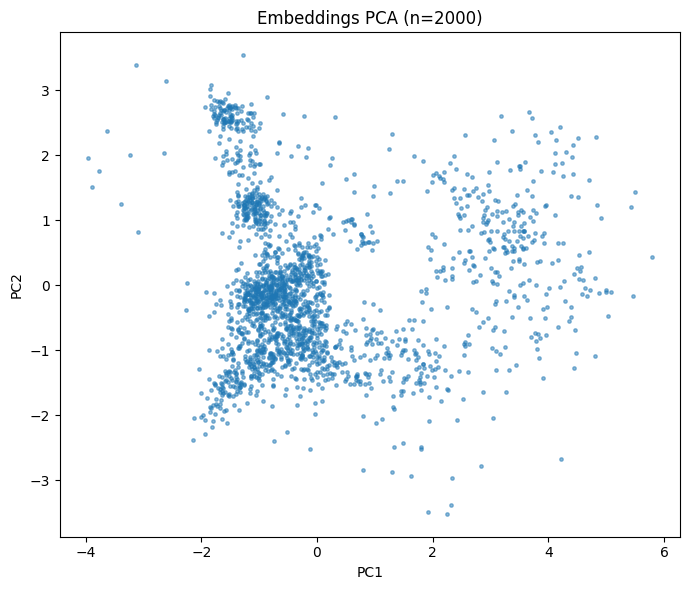

In [4]:
import matplotlib.pyplot as plt

# PCA (via SVD) to 2D for quick visualization (no sklearn dependency)
X = df_emb[[f"embedding_{i}" for i in range(128)]].to_numpy(dtype=np.float32)
X = X - X.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(X, full_matrices=False)
pc2 = U[:, :2] * S[:2]

plt.figure(figsize=(7, 6))
plt.scatter(pc2[:, 0], pc2[:, 1], s=6, alpha=0.5)
plt.title(f"Embeddings PCA (n={len(df_emb)})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()